### Importing Libraries

In [73]:
import re  # For preprocessing
import pandas as pd  # For data handling
import numpy as np
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from sklearn.model_selection import train_test_split
# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [74]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Loading Dataset

In [75]:
#Reading the Data
dataset= pd.read_csv("../input/encoded-rusa/Cleaned_Encoded RUSA Dataset.csv")
dataset = dataset.drop(['Unnamed: 0', 'Review', 'Cleaned_Review','Soundex', 'RefinedSoundex', 'MetaSoundex',
       'FuzzySoundex', 'LEIN', 'NYSIIS', 'Caverphone', 'SoundD', 'Metaphone'], axis=1)
dataset.rename(columns={'Standardized_Review': 'Review'}, inplace=True)
dataset['Sentiment']=dataset['Sentiment'].replace('positive',0)
dataset['Sentiment']=dataset['Sentiment'].replace('negative',1)
dataset.head()

,Sentiment,Review
0,1,ab achanak khawaja sad rafique ko khiyal agay...
1,1,adha drama to censor hi hojaye ga khas tor pe...
2,1,bekaar fuzool end moti budhi laila jeet gayee...
3,1,chor kasuri chor jhootay ka mu kala
4,1,gali gali main shor hai ganja shair chor hai


### Preparing model for Training the Embeddings

In [76]:
from gensim.models.phrases import Phrases, Phraser

In [77]:
sentences = [row.split() for row in dataset['Review']]

In [78]:
phrases = Phrases(sentences, min_count=5, progress_per=100)

In [79]:
bigram = Phraser(phrases)

In [80]:
sentences = bigram[sentences]

In [81]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

24252

In [82]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['hai', 'ki', 'ko', 'to', 'k', 'ka', 'aur', 'se', 'main', 'hi']

In [83]:
import multiprocessing

from gensim.models import Word2Vec

In [84]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

2


In [85]:
w2v_model = Word2Vec(window=10,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [86]:
t = time()

w2v_model.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [87]:
total_examples=w2v_model.corpus_count
print(total_examples)

11000


In [88]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.61 mins


In [89]:
w2v_model.wv.most_similar(positive=["ghatia"])

[('olad', 0.4427710175514221),
 ('az', 0.42016130685806274),
 ('tareen_drama', 0.38042375445365906),
 ('jald', 0.31774115562438965),
 ('selfish', 0.3172512352466583),
 ('fazool', 0.30006060004234314),
 ('lesson', 0.29900169372558594),
 ('ghalti', 0.2922156751155853),
 ('allah_swt', 0.2883652448654175),
 ('over_acting', 0.2848542034626007)]

### Some helper functions

In [90]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    index2word_set = set(vector.wv.index_to_key)
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector.wv[word] if word in index2word_set else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector.wv[word] if word in index2word_set else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data.apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

### Preparing Data and getting Word Embeddings

In [91]:
X= dataset.loc[:,dataset.columns=='Review']
y = dataset.Sentiment

In [92]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [93]:
comments = X.copy()
comments['Review'] = comments['Review'].astype('str') 
comments.dtypes
comments["tokens"] = comments["Review"].apply(tokenizer.tokenize)
comments.head()

,Review,tokens
0,ab achanak khawaja sad rafique ko khiyal agay...,"[ab, achanak, khawaja, sad, rafique, ko, khiya..."
1,adha drama to censor hi hojaye ga khas tor pe...,"[adha, drama, to, censor, hi, hojaye, ga, khas..."
2,bekaar fuzool end moti budhi laila jeet gayee...,"[bekaar, fuzool, end, moti, budhi, laila, jeet..."
3,chor kasuri chor jhootay ka mu kala,"[chor, kasuri, chor, jhootay, ka, mu, kala]"
4,gali gali main shor hai ganja shair chor hai,"[gali, gali, main, shor, hai, ganja, shair, ch..."


In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    comments, y, test_size=0.2, random_state=111)

In [95]:
X_train['Review'].head()

4792      sony ki e4 mobile my touch screen ka problem ...
2339      ab pachtay kia hot jab chirian chug gain khai...
2586      ye kesi democracy he lanat he ppp mqm q leagu...
8477      bilkul sahi kahan razia aur masood ne yeh sub...
10279     sir nawaz sharif ko vote dyn gi is jysa koi l...
Name: Review, dtype: object

In [96]:
X_train_embeddings = pd.DataFrame(get_word2vec_embeddings(w2v_model, X_train['tokens']))
X_test_embeddings = pd.DataFrame(get_word2vec_embeddings(w2v_model, X_test['tokens']))

In [28]:
# X_train_embeddings.shape

In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# RNN

In [34]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [30]:
X_train['Review'].apply(lambda x:len(str(x).split())).max()

422

In [31]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
token.fit_on_texts(list(X_train['Review']) + list(X_test['Review']))
word_index = token.word_index

In [32]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 450

token.fit_on_texts(list(X_train['Review']) + list(X_test['Review']))
xtrain_seq = token.texts_to_sequences(X_train['Review'])
xvalid_seq = token.texts_to_sequences(X_test['Review'])

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [35]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 450, 300)          6990300   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               40100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 7,030,501
Trainable params: 7,030,501
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1.05 s, sys: 771 ms, total: 1.82 s
Wall time: 3.06 s


In [37]:
history = model.fit(xtrain_pad, y_train, epochs=5, 
          batch_size=64, validation_data=(xvalid_pad, y_test)) #Multiplying by ?Strategy to run on TPU's

Epoch 1/5
138/138 [==============================] - 55s 396ms/step - loss: 0.0480 - accuracy: 0.9872 - val_loss: 0.6622 - val_accuracy: 0.7595
Epoch 2/5
138/138 [==============================] - 54s 391ms/step - loss: 0.0154 - accuracy: 0.9972 - val_loss: 0.6926 - val_accuracy: 0.7827
Epoch 3/5
138/138 [==============================] - 53s 383ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.7622 - val_accuracy: 0.7564
Epoch 4/5
138/138 [==============================] - 55s 400ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.8058 - val_accuracy: 0.7805
Epoch 5/5
138/138 [==============================] - 54s 390ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 0.8152 - val_accuracy: 0.7509


In [40]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [52]:
%%time
y_train_pred = model.predict_classes(xtrain_pad)
y_test_pred = model.predict_classes(xvalid_pad)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 10.1 s, sys: 110 ms, total: 10.2 s
Wall time: 9.96 s


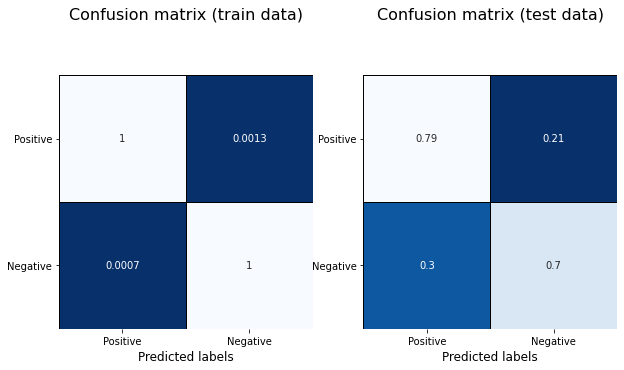

In [58]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

In [62]:
# history.history

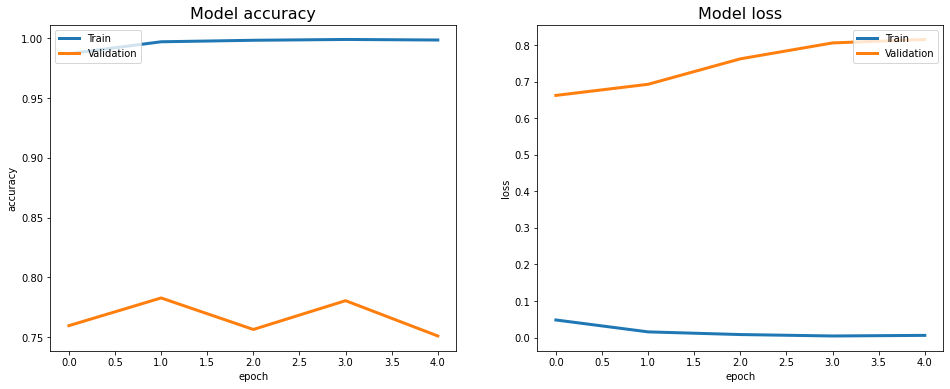

In [63]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.savefig("RNN_Graphs")
plt.show()

# LSTM

In [97]:
X_train_embeddings = np.array(X_train_embeddings)
X_test_embeddings = np.array(X_test_embeddings)

In [98]:
# type(X_train_embeddings)

In [99]:
X_train_embeddings = X_train_embeddings.reshape((X_train_embeddings.shape[0], X_train_embeddings.shape[1], 1))
X_test_embeddings = X_test_embeddings.reshape((X_test_embeddings.shape[0], X_test_embeddings.shape[1], 1))

In [100]:
# X_train_embeddings.shape

In [101]:
# X_test_embeddings.shape

In [109]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(LSTM(150, dropout=0.3, recurrent_dropout=0.3, input_shape = (300, 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________
CPU times: user 133 ms, sys: 4.77 ms, total: 138 ms
Wall time: 138 ms


In [115]:
history = model.fit(X_train_embeddings, y_train, epochs=50, 
          batch_size=64, validation_data=(X_test_embeddings, y_test))

Epoch 1/50
138/138 [==============================] - 135s 980ms/step - loss: 0.5979 - accuracy: 0.6670 - val_loss: 0.5686 - val_accuracy: 0.6877
Epoch 2/50
 56/138 [===========>..................] - ETA: 1:17 - loss: 0.5918 - accuracy: 0.6783

KeyboardInterrupt: 

In [ ]:
%%time
y_train_pred = model.predict_classes(X_train_embeddings)
y_test_pred = model.predict_classes(X_test_embeddings)

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.savefig("LSTM_Graphs")
plt.show()

# Bidirectional LSTM

In [165]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, input_shape = (300, 1))))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
# model.summary()
history = model.fit(X_train_embeddings, y_train, epochs=50, 
          batch_size=64, validation_data=(X_test_embeddings, y_test))

Epoch 1/2
138/138 [==============================] - 281s 2s/step - loss: 0.6664 - accuracy: 0.6040 - val_loss: 0.6303 - val_accuracy: 0.6641
Epoch 2/2
138/138 [==============================] - 278s 2s/step - loss: 0.6412 - accuracy: 0.6251 - val_loss: 0.6194 - val_accuracy: 0.6573
CPU times: user 14min 23s, sys: 1min 50s, total: 16min 13s
Wall time: 9min 19s


In [169]:
%%time
y_train_pred = model.predict_classes(X_train_embeddings)
y_test_pred = model.predict_classes(X_test_embeddings)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 46.4 s, sys: 1.18 s, total: 47.6 s
Wall time: 44.8 s


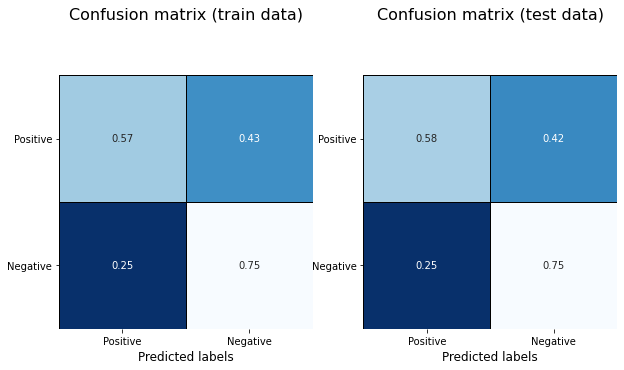

In [170]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

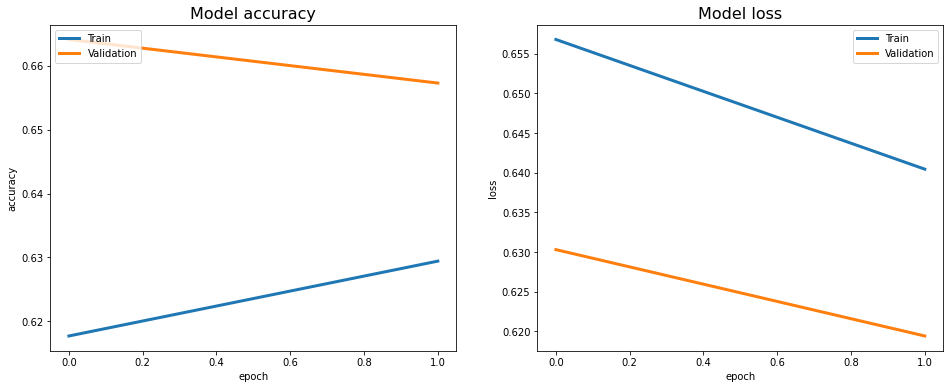

In [171]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.savefig("Bi_LSTM_Graphs")
plt.show()